In [1]:
# Import data and libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r'/content/drive/MyDrive/Data Science in Finance/python-material/Final Project/data/data_for_modelling.csv')


In [2]:
df['loan_default'] = df.loan_status == "Charged Off"
df['loan_default'].value_counts()

,count
loan_default,
False,84911
True,12382


In [3]:
df.head()
df_correlatable = df.select_dtypes(include=['float64'])
correlations = df_correlatable.corrwith(df['loan_default']).sort_values(ascending=False)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [4]:
actionable_correlations = correlations[abs(correlations)>=0.5]
display(actionable_correlations)

,0
recoveries,0.548655
collection_recovery_fee,0.528997
hardship_dpd,0.505924
last_fico_range_low,-0.560009
last_fico_range_high,-0.609832


In [5]:
features = ['fico_range_high', 'fico_range_low', 'annual_inc', 'dti']

In [6]:
df[features].corrwith(df['loan_default']).sort_values(ascending=False)

,0
dti,0.021973
annual_inc,-0.033476
fico_range_high,-0.119593
fico_range_low,-0.119596


**Analysis of features and whether to include or exclude them**


1.   Recoveries - post-default metric, can't be used
     as a predictor.
2.   Collection Recovery Fee - is again a post-default
     metric and can't be used.

Including these two would cause 'data leakage', which occurs when a model uses information not available at the time an input is created. These can cause figures regarding performance to be incorrect and potentially cause overfitting.

3.   FICO high and low - are effectively included in the features already, and adding them would cause redundancies that could slow the model down.

This leaves us with one feature to add that could be useful and that is the hardship_dpd column. It gives us a good indicator of the borrower's financial situation before defaulting and therefore could improve the model.



**Feature Engineering**

I am going to create one more feature to add to this model to improve the model. I don't want to add too many features as this can increase the likelihood of multicollinearity and overfit the model. Therefore I am going to assess the existing features and see if any can be modified or adjusted to better tailor the data.

In [7]:
df[features].describe()

,fico_range_high,fico_range_low,annual_inc,dti
count,97293.000000,97293.000000,9.729300e+04,97195.000000
mean,704.437277,700.437030,7.884601e+04,19.328769
std,33.715960,33.714898,8.698824e+04,17.101851
min,644.000000,640.000000,0.000000e+00,-1.000000
25%,679.000000,675.000000,4.679100e+04,12.060000
50%,699.000000,695.000000,6.500000e+04,18.110000
75%,724.000000,720.000000,9.420000e+04,24.890000
max,850.000000,845.000000,1.099920e+07,999.000000




1.   FICO high and low both have relatively small standard deviations, showing a likelihood of a concentration of points around the mean. These columns could be combined to make a FICO_average.
2.   Annual Income shows a very high degree of standard deviation, even higher than the mean. This indicates a highly skewed dataset, and some kind of scaling may be necessary to fix this. The maximum is an extreme outlier and should be dropped. There is also a 0 value (potentially multiple), and these rows will need to be analysed to see if those rows should be dropped.
3.   Debt to income has missing values, and therefore these need to be imputed (either via the mean, as done in model_1, or via another method).

I am going to address the annual_inc column, applying a log transformation will reduce the skew. I am also going to drop the row containing the maximum value (extreme outlier), and explore the 0 value/s and see if any more rows need to be dropped.



In [8]:
#Showing values for row where the extreme outlier is stored
df.loc[df['annual_inc'].idxmax()]
#Dropping the row containing outlying max salary
df_no_extreme_income = df.drop(df['annual_inc'].idxmax())
df[df['annual_inc']==0]

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag_Y,last_pymnt_amnt_log,emp_title_clean,emp_title_manager,Job Title,Category,term_encoded,percent_funded,loan_amnt_percent_of_total_balance,loan_default
1108,1108,125097285,40000.0,40000.0,40000.0,36 months,18.06%,1447.31,D,D2,...,0.0,7.278153,NaN,NaN,NaN,NaN,0,1.0,1.850139,False
2670,2670,92220713,20000.0,20000.0,20000.0,60 months,11.44%,439.25,B,B4,...,0.0,6.087343,co-owner,False,NaN,NaN,1,1.0,0.756888,False
4863,4863,146355577,22200.0,22200.0,22200.0,36 months,6.46%,680.01,A,A1,...,0.0,6.523577,NaN,NaN,NaN,NaN,0,1.0,1.068284,False
8141,8141,157813948,39000.0,39000.0,39000.0,60 months,20.55%,1045.24,D,D2,...,0.0,6.952958,NaN,NaN,NaN,NaN,1,1.0,5.216693,False
8347,8347,149181780,5000.0,5000.0,5000.0,36 months,22.50%,192.25,D,D3,...,0.0,5.263985,NaN,NaN,NaN,NaN,0,1.0,0.054726,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86494,86494,148544029,8000.0,8000.0,8000.0,36 months,13.90%,273.04,C,C1,...,0.0,5.613274,NaN,NaN,NaN,NaN,0,1.0,1.449801,False
88170,88170,157344518,6000.0,6000.0,6000.0,36 months,15.24%,208.70,C,C2,...,0.0,5.345678,NaN,NaN,NaN,NaN,0,1.0,0.046814,False
88292,88292,114179715,35000.0,35000.0,35000.0,36 months,17.09%,1249.42,D,D1,...,0.0,9.463384,NaN,NaN,NaN,NaN,0,1.0,0.471076,False
90998,90998,149669268,8000.0,8000.0,8000.0,36 months,6.46%,245.05,A,A1,...,0.0,5.505535,NaN,NaN,NaN,NaN,0,1.0,0.045793,False


There are 100 rows with 0 income, which is 0.01% (which is small, but not insignificant). It would be prudent to see if they are normally distributed, or if they are highly correlated with a specific variable. Another option would be to change the 0 to 1, as that would allow the log transformation to work.

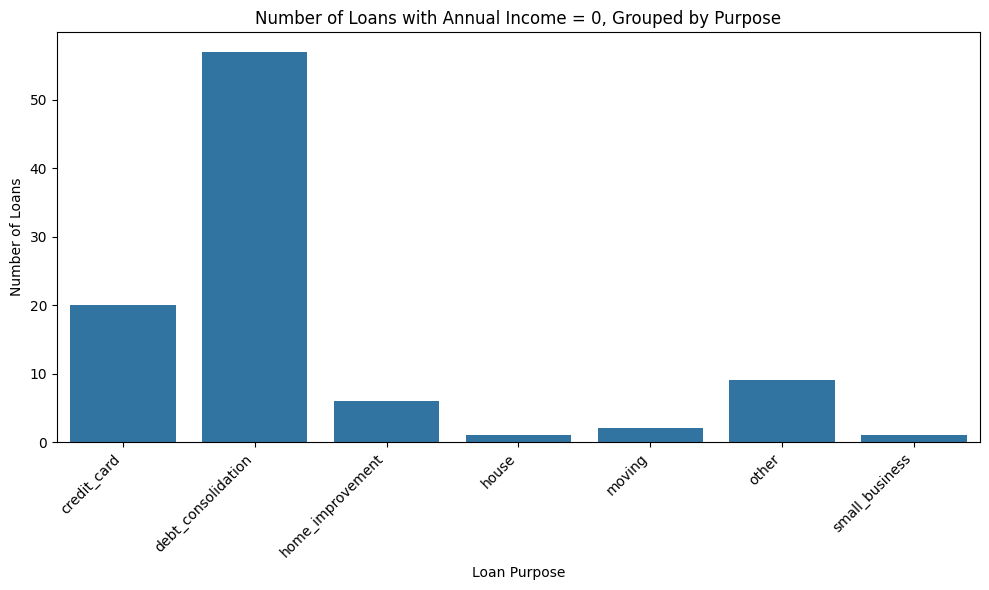

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for annual income equal to 0
zero_income_df = df_no_extreme_income[df_no_extreme_income['annual_inc'] == 0]

# Group by loan purpose and count occurrences
purpose_counts = zero_income_df.groupby('purpose')['annual_inc'].count()

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=purpose_counts.index, y=purpose_counts.values)
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.title('Number of Loans with Annual Income = 0, Grouped by Purpose')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

We can see that the large majority of the values come from debt_consolidation. 0.01% of values is still significantly small, and unlikely to affect anything, so I am going to change the values from 0 to 1.


In [10]:
df_no_extreme_income['adjusted_annual_inc'] = df['annual_inc'].replace(0, 1)

In [11]:
df_no_extreme_income['hardship_dpd'].fillna(0, inplace=True)
df_no_extreme_income['dti'].fillna(0,inplace=True)

<ipython-input-11-4c4ad704c5b7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_no_extreme_income['hardship_dpd'].fillna(0, inplace=True)
<ipython-input-11-4c4ad704c5b7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [12]:
#Create list of new features
new_features = ['fico_range_high', 'fico_range_low', 'adjusted_annual_inc', 'dti','hardship_dpd']

In [13]:
X = df_no_extreme_income[new_features]
y = df_no_extreme_income['loan_default']
# Initialize and train the Logistic Regression model
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Create a pipeline containing an imputer and scaler to handle NaNs
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(class_weight = 'balanced'))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
predictions_2 = pipeline.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate metrics
accuracy_2 = accuracy_score(y_test, predictions_2)
precision_2 = precision_score(y_test, predictions_2)
recall_2 = recall_score(y_test, predictions_2)
f1_2 = f1_score(y_test, predictions_2)
roc_auc_2 = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])

# Display the confusion matrix
cm_2 = confusion_matrix(y_test, predictions_2)

print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
print(f'F1-Score: {f1_2}')
print(f'ROC-AUC: {roc_auc_2}')
print(f'Confusion Matrix:\n{cm_2}')

from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_scores_2 = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores_2}')
print(f'Mean CV Accuracy: {cv_scores_2.mean()}')

Shape: (77833, 5)
Shape: (19459, 5)
Shape: (77833,)
Shape: (19459,)
Accuracy: 0.532504239683437
Precision: 0.16862390846130684
Recall: 0.673616680032077
F1-Score: 0.26972786385164965
ROC-AUC: 0.6279494482602631
Confusion Matrix:
[[8682 8283]
 [ 814 1680]]
Cross-Validation Accuracy Scores: [0.52654299 0.53337787 0.52492548 0.53088704 0.53499846]
Mean CV Accuracy: 0.5301463673464977


As we can see there are some distinct changes:

1.   The accuracy has dropped, most notably. This isn't necessarily a bad thing, as looking at the other metrics for the first model, it is clear that it was mainly predicting non-defaulted loans. Therefore the drop in accuracy here could be indicative of the fact that the model is capturing some defaults.
2.   This is confirmed by the fact that the precision, recall and f-1 are now better for model_2 than model_1. This means that the accuracy is lower, but it is accurately predicting defaults more often.
3.   ROC-AUC has also improved.

Now is a good time to implement some hyperparameter tuning. I am going to use GridsearchCV to do this.



In [14]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'scaler__with_scaling': [True, False],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2','elasticnet'],
    'model__solver': ['newton-cg','saga']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best model:", grid_search.best_score_)
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test,y_test)
print(f"Test Accuracy of best model: {test_score}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, *

Best Parameters: {'imputer__strategy': 'mean', 'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'newton-cg', 'scaler__with_scaling': False}
Best model: 0.16476135535205783
Test Accuracy of best model: 0.5326070198879695


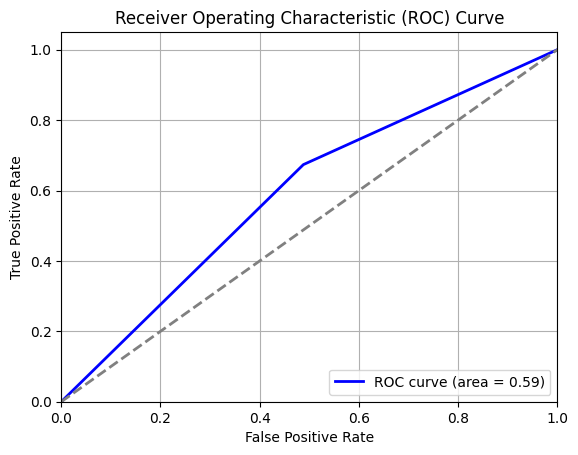

ROC AUC Score: 0.59


In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Compute ROC curve and ROC AUC
y_pred = best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred):.2f}')

In [16]:
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"F1-score: {f1}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.16865776528461
F1-score: 0.269771176234444
Recall: 0.673616680032077
ROC AUC: 0.5927470373340461


As we can see the recall is quite strong. However, the precision is low meaning it is still sending out a lot of false positives, which is causing the F1 score to be lower. We can try implementing a SMOTE to see if it can rectify any undersampling in our model.

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [25]:
best_model.fit(X_resampled, y_resampled)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('scaler', RobustScaler(with_scaling=False)),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    solver='newton-cg'))])

In [26]:
y_pred1 = best_model.predict(X_test)

In [27]:
print(f"Precision: {precision_score(y_test, y_pred1)}")
print(f"F1-score: {f1_score(y_test, y_pred1)}")
print(f"Recall: {recall_score(y_test, y_pred1)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred1)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred1)}")

Precision: 0.16854952592293726
F1-score: 0.26934235976789167
Recall: 0.6700080192461909
ROC AUC: 0.5920626597851939
Accuracy: 0.5340973328536924
